---
title: Creating Timeseries with the NLDAS-3 Data
description: NLDAS3 makes it easy to visualize how environmental variables have changed over time.
author: Rishi Anand
date: July 26, 2024
execute:
   freeze: true
---

In [1]:
# import libraries
from matplotlib import pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
from __future__ import print_function
import boto3
import s3fs
import rioxarray
import rasterio
from rasterio.io import MemoryFile
import os
import tempfile
import shutil
from boto3.session import Session

#### The files are stored in Project VEDA's AWS cloud storage platform, so they can be accessed easily with the correct credentials from any environment.

In [2]:
# Set up global variables

# Indicates the folder where the NLDAS files are found in Discover
directory=r'/discover/nobackup/fmaina/veda_story/nldas3/'

# Define the Lat/Long boundaries of the data for rescaling later
nldasExtent = {
    "x0":-169.0,
    "xn":-52.0,
    "y0":7.0,
    "yn":72.0
}

#Temporary credentials, get them from Rishi Anand


#### The data needs to be rescaled to work properly, as there was an encoding error related to one of the axes.

In [3]:
# This function is used to generate rescaled axes, and will be used to convert the NLDAS data to Lat/Long axes
def scaleAxes(x, y, x0, xn, y0, yn):
    newX = np.array(x)
    newY = np.array(y)
    newX = newX * (xn-x0)/len(x)
    newY = newY * (yn-y0)/len(y)
    medX = np.median(newX)
    medY = np.median(newY)
    newX = newX-medX+((x0+xn)/2)
    newY = newY-medY+((y0+yn)/2)
    
    return [newX, newY]

# This function reads the files from directory starting with initYear and processes yearsToProcess years
def getNLDASFilesForYrRange(initYear=2019, yearsToProcess=1):
    print("Reading stored files...")
    # The returned list of data
    results = []
    # A list of dates associated with each datapoint, will be returned alongside results
    dates = []

    fs = s3fs.S3FileSystem(anon=False, 
                           key=credentials[''], 
                           secret=credentials[''],
                           token=credentials[''],
                           client_kwargs={
                           'endpoint_url':'https://s3.us-west-2.amazonaws.com'
                           })
    aws_url = 's3://veda-data-store-staging/'
    
    # Go through the files month by month
    for month in range(int(12 * yearsToProcess)):
        
        #Convert from raw month into year and month of year (Jan == 01)
        year = month//12+initYear
        monthOfYear = month%12+1
        if month%12==0:
            print(year)
        
        # Format the year and month of year to the standard filename format
        yrMnth = str(year) + str(monthOfYear).zfill(2)
        nc = xr.open_dataset(fs.open(aws_url+"EIS/NLDAS3MonthlyData/LIS_HIST_"+yrMnth+".nc")) # reading the nc file and creating Dataset
        nc = nc.set_coords(("lat", "lon")).drop_vars(['latitude', 'longitude'])
        
        # Rescalin the axes to Lat/Long
        axes = scaleAxes(nc["longitude"], nc["latitude"], nldasExtent["x0"], nldasExtent["xn"], nldasExtent["y0"], nldasExtent["yn"])
        nc["latitude"] = axes[1]
        nc["longitude"] = axes[0]
        results.append(nc)
    
    #Iterate through all used dates as datetimes and add them to dates
    nextM = datetime.date(initYear, 1, 1)
    end = datetime.date(initYear+yearsToProcess-1, 12, 1)    

    while nextM <= end:
        dates.append(nextM)
        nextM += relativedelta(months=1)
    
    # Return generated data and corresponding dates in a dict
    return {
        "data":results,
        "dates":dates
    }

In [4]:
#Grab the data to analyze
data = getNLDASFilesForYrRange(initYear=2018, yearsToProcess=2)

Reading stored files...
2018
2019


In [5]:
# Returns timeseries data for given lat/long point in the given dataset ds
# trimNan stops the operation if the first returned value is empty, and is used to save time if we are iterating over water/ocean
def dataForLatLong(lat, long, ds, trimNan=False):
    ts = []
    for img in ds:
        ts.append(img.sel(latitude=lat, longitude=long)["Precep"].to_numpy())
        #Exit code
        if np.isnan(ts[0]) and trimNan:
            return ts
    return ts

# Create a timeseries for the variable data at lat/long
def generatePrecipGraph(lat, long, ts, data):
    print(float(lat), float(long))
    plt.plot(data["dates"], ts)
    plt.title("Precipitation at Coords. " + "{:.2f}ºN".format(float(lat)) + ", " + "{:.2f}ºE".format(float(long)))
    plt.ylabel("Precipitation (mm)")
    plt.xlabel("Date")
    plt.show()

# A function to find the value in a list closest to an input value
# Will be used so that a user can check the value at a lat/long without knowing the exact coordinate that is stored
def closest(lst, K):
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]


# Get the timeseries for a specific lat/long
def showLLGraph(lat, lon, data):
    cLat = closest(data["data"][0]["latitude"], lat)
    cLon = closest(data["data"][0]["longitude"], lon)
    generatePrecipGraph(cLat, cLon, dataForLatLong(cLat.to_numpy(), cLon.to_numpy(), data["data"], trimNan=False), data)
    print(lat, cLat, lon, cLon)

#### The data's format makes it simple to create a graph tracking envrionmental changes over time. For example, here's the graph for GSFC.

39.000307503075035 -76.8515037593985


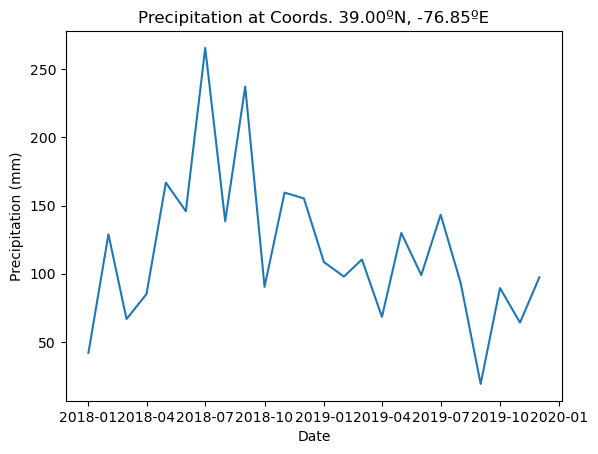

38.99503121494009 <xarray.DataArray 'latitude' ()> Size: 8B
array(39.0003075)
Coordinates:
    latitude  float64 8B 39.0 -76.85235265620067 <xarray.DataArray 'longitude' ()> Size: 8B
array(-76.85150376)
Coordinates:
    longitude  float64 8B -76.85


In [6]:
#Example of getting a graph for a desired coordinate
showLLGraph(38.99503121494009, -76.85235265620067, data)